In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import math
from numpy import log, exp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as LR
from scipy.optimize import minimize
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
!head ../data/experimental/all_scaled_nn_preds.txt

flank	protein	NN_ddG	intercept	slope	scaled_ddG	scaled_dG
AAAAAAAAAA	Cbf1	0.292390204780521	-9.97089467415464	4.8170440481437	1.40845649567352	-8.56243817848112
AAAAAAAAAC	Cbf1	0.234923995845737	-9.97089467415464	4.8170440481437	1.13163923595484	-8.8392554381998
AAAAAAAAAG	Cbf1	0.271561421268405	-9.97089467415464	4.8170440481437	1.30812332802641	-8.66277134612823
AAAAAAAAAT	Cbf1	0.293640024774493	-9.97089467415464	4.8170440481437	1.41447693363674	-8.5564177405179
AAAAAAAACA	Cbf1	0.214518554323138	-9.97089467415464	4.8170440481437	1.03334532531866	-8.93754934883598
AAAAAAAACC	Cbf1	0.171366102807941	-9.97089467415464	4.8170440481437	0.825478065584572	-9.14541660857007
AAAAAAAACG	Cbf1	0.203596807830753	-9.97089467415464	4.8170440481437	0.980734791382183	-8.99015988277246
AAAAAAAACT	Cbf1	0.240502871387424	-9.97089467415464	4.8170440481437	1.15851292517826	-8.81238174897638
AAAAAAAAGA	Cbf1	0.269228316657962	-9.97089467415464	4.8170440481437	1.29688466034898	-8.67401001380566


In [3]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("../data/experimental/all_scaled_nn_preds.txt") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank,protein,_,_,_,ddG,_ = line.strip().split('\t')
        if protein == "Cbf1": flankToCbf1Ddg[flank] = float(ddG)
        else: flankToPho4Ddg[flank] = float(ddG)
        allFlanks.append(flank)
allFlanks = list(set(allFlanks))

In [4]:
sampled_keys = np.random.choice(allFlanks, 110000, replace=False)
sampled_valid_keys = sampled_keys[100000:]
sampled_keys = sampled_keys[:100000]

In [5]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

def logit(p):
    return log(p) - log(1 - p)

In [6]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class LinearRegression(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose 

    def __call__(self, valid_preacts, valid_labels):
        lr = LR().fit(valid_preacts.reshape(-1, 1), valid_labels)
    
        def calibration_func(preact):
            return lr.predict(preact.reshape(-1, 1))

        return calibration_func

class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class SigmoidFit(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def __call__(self, valid_preacts, valid_labels):
        def loss_func(x):
            new_preacts = (x[0]*sigmoid(-valid_labels+x[1]))+x[2]
            return mean_squared_error(new_preacts, valid_preacts)

        x0 = np.array([1.0, 0.0, 0.0])
        res = None
        for c in range(10):
            curr = minimize(loss_func, x0, method='BFGS', options={'gtol': 1e-9, 'disp': True, 'maxiter': 1000})
            if res == None or curr.fun < res.fun:
                res = curr
        print("multiplier: ",res.x[0],", in sigmoid bias: ",res.x[1],", out of sigmoid bias: ",res.x[2])

        def calibration_func(label):
            return (res.x[0]*sigmoid(-label+res.x[1]))+res.x[2]

        def inv_func(preact):
            return -logit((preact-res.x[2])/res.x[0])+res.x[1]

        return calibration_func, inv_func

In [7]:
obj_text1 = codecs.open("../data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToChPCbf1Preds = json.loads(obj_text1)

In [8]:
obj_text2 = codecs.open("../data/preds/pbexo.pho4.gcmatched.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToMatchedChPCbf1Preds = json.loads(obj_text2)

In [9]:
sampleChPCbf1Preds = {}
sampleChPCbf1LogPreds = {}
sampleMatchedChPCbf1Preds = {}
sampleMatchedChPCbf1LogPreds = {}
for key in sampled_keys:
    y_0 = np.array(flankToChPCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToChPCbf1Preds[key][1]).astype(float)
    sampleChPCbf1LogPreds[key] = np.mean(y_1-y_0)
    sampleChPCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_0 = np.array(flankToMatchedChPCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToMatchedChPCbf1Preds[key][1]).astype(float)
    sampleMatchedChPCbf1LogPreds[key] = np.mean(y_1-y_0)
    sampleMatchedChPCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
for key in sampled_valid_keys:
    y_0 = np.array(flankToChPCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToChPCbf1Preds[key][1]).astype(float)
    sampleChPCbf1LogPreds[key] = np.mean(y_1-y_0)
    sampleChPCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_0 = np.array(flankToMatchedChPCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToMatchedChPCbf1Preds[key][1]).astype(float)
    sampleMatchedChPCbf1LogPreds[key] = np.mean(y_1-y_0)
    sampleMatchedChPCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))

In [10]:
%matplotlib inline

def plotCorrs(yvals, xvals, ylabel, xlabel):
    if np.isnan(yvals).any() or np.isinf(yvals).any(): return
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    axes = plt.gca()
    p, residuals, _, _, _ = np.polyfit(xvals, yvals, 1, full=True)
    m, b = p
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("spearman: "+str(spearmanr(xvals, yvals))+
              ", pearson: "+str(pearsonr(xvals, yvals))+
              ", residuals: "+str(residuals))
    plt.show()

Standard Cbf1 ChIP exo

In [11]:
valid_log_preacts = []
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_log_preacts.append(sampleChPCbf1LogPreds[key])
    valid_preacts.append(sampleChPCbf1Preds[key])
    valid_labels.append(flankToPho4Ddg[key])
valid_log_preacts = np.array(valid_log_preacts)
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

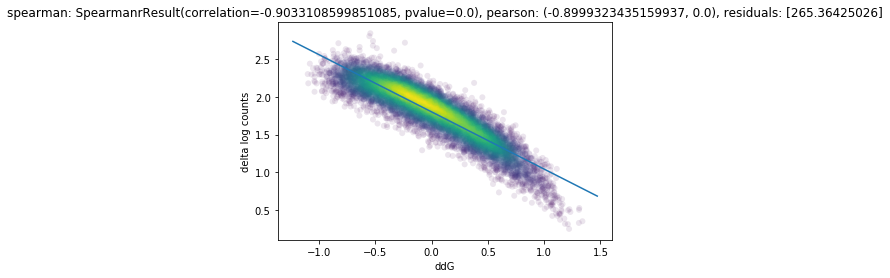

In [12]:
plotCorrs(valid_log_preacts, valid_labels, "delta log counts", "ddG")

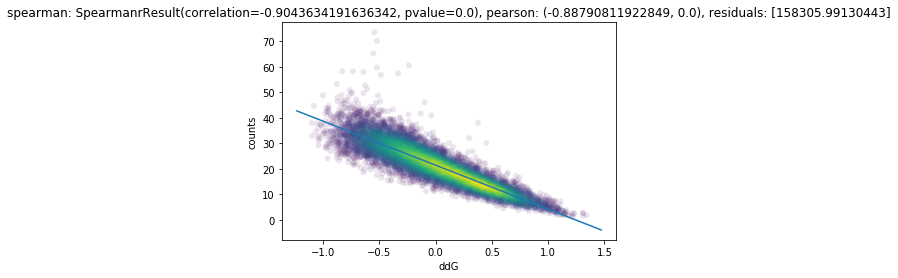

In [13]:
plotCorrs(valid_preacts, valid_labels, "counts", "ddG")

Baseline

In [14]:
log_preacts = []
preacts = []
labels = []
for key in sampled_keys:
    log_preacts.append(sampleChPCbf1LogPreds[key])
    preacts.append(sampleChPCbf1Preds[key])
    labels.append(flankToPho4Ddg[key])
log_preacts = np.array(log_preacts)
preacts = np.array(preacts)
labels = np.array(labels)

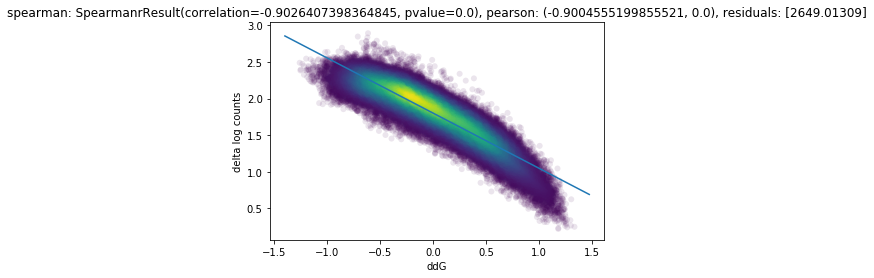

In [15]:
plotCorrs(log_preacts, labels, "delta log counts", "ddG")

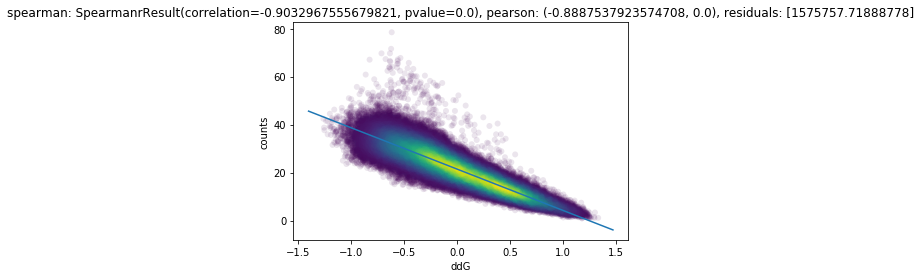

In [16]:
plotCorrs(preacts, labels, "counts", "ddG")

Linear fit with counts

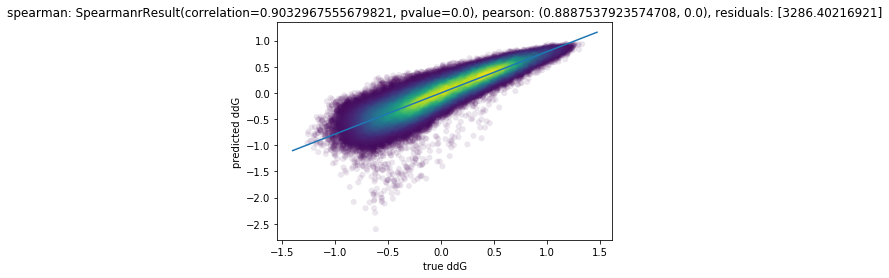

In [17]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Linear fit with log counts

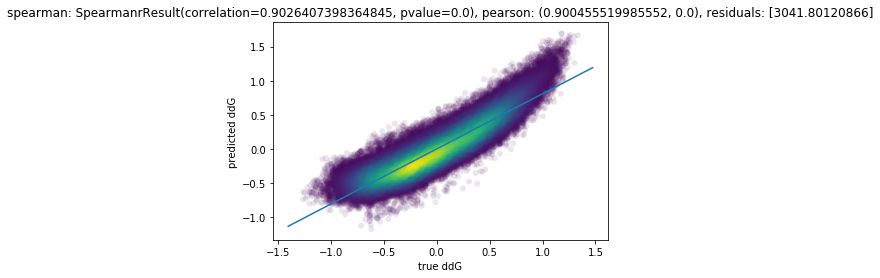

In [18]:
lr = LinearRegression()
calibration_func = lr(valid_log_preacts, valid_labels)
calibrated_labels = calibration_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Logit fit with counts

In [19]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = inv_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
         Iterations: 50
         Function evaluations: 461
         Gradient evaluations: 92
         Current function value: 15.691958
     

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


Logit fit with log counts

In [20]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_log_preacts, valid_labels)
calibrated_labels = inv_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iterations: 45
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 0.022581
         Iter

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


Matched Cbf1 ChIP exo

In [21]:
valid_log_preacts = []
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_log_preacts.append(sampleMatchedChPCbf1LogPreds[key])
    valid_preacts.append(sampleMatchedChPCbf1Preds[key])
    valid_labels.append(flankToPho4Ddg[key])
valid_log_preacts = np.array(valid_log_preacts)
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

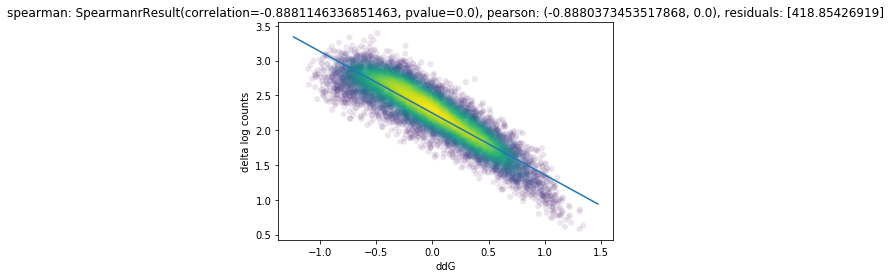

In [22]:
plotCorrs(valid_log_preacts, valid_labels, "delta log counts", "ddG")

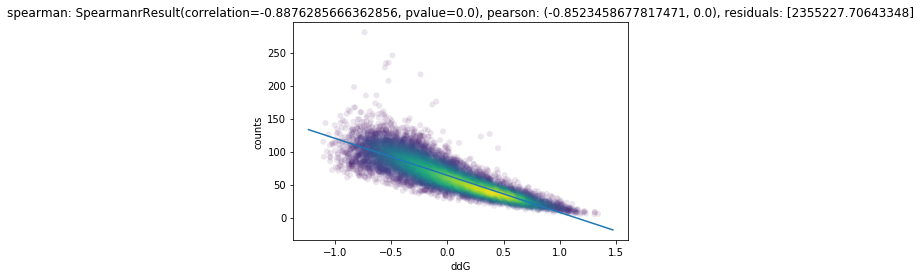

In [23]:
plotCorrs(valid_preacts, valid_labels, "counts", "ddG")

Baseline

In [24]:
log_preacts = []
preacts = []
labels = []
for key in sampled_keys:
    log_preacts.append(sampleMatchedChPCbf1LogPreds[key])
    preacts.append(sampleMatchedChPCbf1Preds[key])
    labels.append(flankToPho4Ddg[key])
log_preacts = np.array(log_preacts)
preacts = np.array(preacts)
labels = np.array(labels)

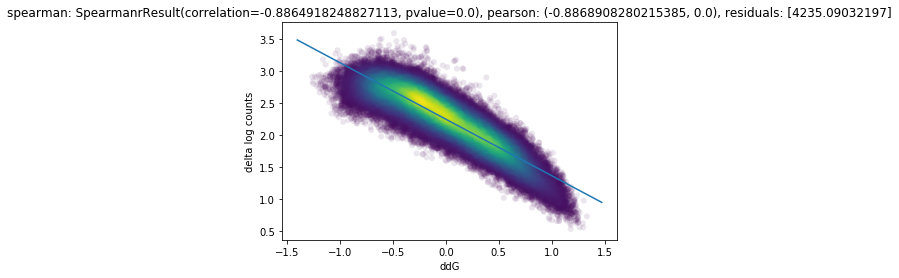

In [25]:
plotCorrs(log_preacts, labels, "delta log counts", "ddG")

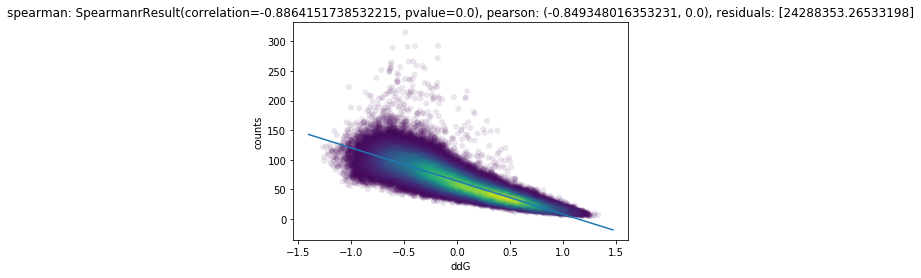

In [26]:
plotCorrs(preacts, labels, "counts", "ddG")

Linear fit with counts

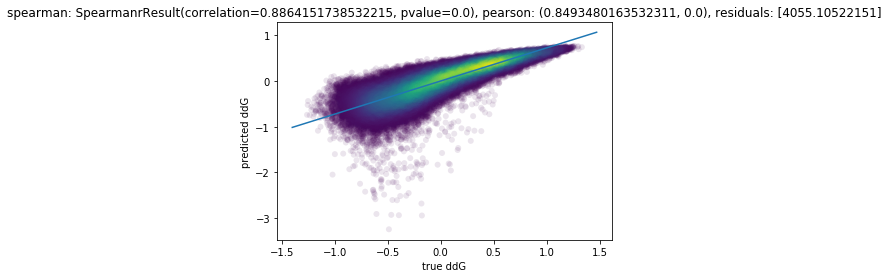

In [27]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Linear fit with log counts

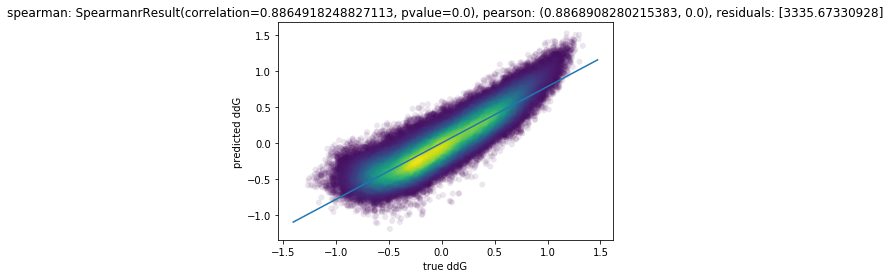

In [28]:
lr = LinearRegression()
calibration_func = lr(valid_log_preacts, valid_labels)
calibrated_labels = calibration_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Logit fit with counts

In [29]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = inv_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.499814
         Iterations: 27
         Function evaluations: 251
         Gradient evaluations: 50
         Current function value: 232.4998

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


Logit fit with log counts

In [30]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_log_preacts, valid_labels)
calibrated_labels = inv_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iterations: 45
         Function evaluations: 301
         Gradient evaluations: 60
         Current function value: 0.037314
         Iter

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log
